## **Traffic Volume Counting Using YOLO Object Detector**

This is a program to automatically detect and count
vehicles passing through a corridor in a certain direction. For this purpose, we
implemented a commonly used object detector called YOLO (You only look once)
which takes the input frames from a video file and outputs a bounding box for
every vehicle visible in the image. We used YOLO v5 for this purpose which can be accessed through the Pytorch library. Next, we defined a reference line and a direction set by the user to determine where the bounding box stands in relation to this line. This line is defined by taking two points from the user. Once the center of the bounding box for a certain vehicle passes this reference line between two consecutive frames, we count it as a new vehicle and update the total count.

This process is repeated for every frame of the input video. We use OpenCV for
processing the video file, extracting frames, and drawing additional information
on the output video containing the count. We also store the count data in a CSV
file with the timestamp for each vehicle detected. Pandas
was used for this purpose. This data can then be aggregated to extract counts for any desired interval such as hourly count. This process does not need any
individual training and only uses off-the-shelf resources readily available to public.

This code uses GPU for faster processing. Please select "Runtime" from colab menus, then select "Change runtime type" and choose "T4 GPU".

* For detailed instructions on how to use google colab, visit: [google colab tutorial](https://github.com/WiktorJ/google-colab-tutorial)


# ***Step 1: Prepare the model***  


Run this snippet to load YOLO github repository to your notebook

In [1]:
# @markdown ### Run this to load YOLO github repository

import os
!git clone https://github.com/ultralytics/yolov5
os.chdir('/content/yolov5')

Cloning into 'yolov5'...
remote: Enumerating objects: 16057, done.
remote: Total 16057 (delta 0), reused 0 (delta 0), pack-reused 16057
Receiving objects: 100% (16057/16057), 14.68 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (11032/11032), done.


The next snipped of code is the necessary functions we need to display and process our input video.

In [2]:
# @markdown ### Run this to load helper functions.
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

def is_above(p1, p2, p3):
    """
    Returns True if p3 is above the line formed by p1 and p2, False otherwise.
    """
    buffer=20
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    # Calculate the slope of the line between p1 and p2
    m = (y2 - y1) / (x2 - x1)
    # Calculate the y-intercept of the line
    b = y1 - m * x1
    # Calculate the y-value of the line at x3
    y_line = m * x3 + b
    # Compare the y-value of the line to the y-value of p3
    if Direction=='A':
      default_bool= False
    else:
      default_bool=True

    if y3 > (y_line +buffer) and min(x1,x2)<x3<max(x1,x2):
        return False
    elif y3 <= (y_line - buffer) and min(x1,x2)<x3<max(x1,x2):
        return True
    else:
        return default_bool
def draw_arrows(ax, p1, p2,w,h):
    """
    Draws two perpendicular arrows on the input Matplotlib axis.
    The arrows are centered at the midpoint between p1 and p2,
    with a distance of 10 pixels between them.
    """
    # Calculate the midpoint between p1 and p2
    midpoint = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

    # Calculate the angle of the line between p1 and p2
    angle = np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

    # Calculate the perpendicular angle to the line between p1 and p2
    perp_angle = angle - np.pi / 2

    # Calculate the starting points of the arrows
    arrow_distance  = int(np.floor(h/15)) #The distance of the arrow from the line
    arrow_size = int(np.floor(h/20))   # Length of Arrow

    p3 = (midpoint[0] + arrow_distance * np.cos(perp_angle),
          midpoint[1] + arrow_distance * np.sin(perp_angle))
    p5 = (midpoint[0] - arrow_distance * np.cos(perp_angle),
          midpoint[1] - arrow_distance * np.sin(perp_angle))

    # Calculate the endpoints of the arrows
    p4 = (p3[0] + arrow_size * np.cos(angle + np.pi / 2),
          p3[1] + arrow_size * np.sin(angle + np.pi / 2))
    p6 = (p5[0] + arrow_size * np.cos(angle - np.pi / 2),
          p5[1] + arrow_size * np.sin(angle - np.pi / 2))

    # Draw the arrows
    ax.annotate('', xytext=p3, xy=p4,
                arrowprops=dict(arrowstyle='<-', color='r', lw=3))
    ax.annotate('', xytext=p5, xy=p6,
                arrowprops=dict(arrowstyle='<-', color='r', lw=3))

    # Add text labels for the arrows
    font_size = 20
    label_offset = 5
    ax.text(p3[0] - label_offset, p3[1], 'A', color='r', fontsize=font_size,
            horizontalalignment='right', verticalalignment='center')
    ax.text(p5[0] + label_offset, p5[1], 'B', color='r', fontsize=font_size,
            horizontalalignment='left', verticalalignment='center')

    A=(p3,p4)
    B=(p5,p6)
    return A,B
def annotate_yolo_results(result,image, confidence_threshold=0.5):
    """Annotates YOLOv5 detection results with bounding boxes and labels using OpenCV"""
    # img = result.ims[0] # get the image
    img=image.copy()
    labels = result.names # get the label names
    bboxes = result.xyxy[0] # get the bounding boxes for the objects
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image from BGR to RGB format

    # annotate the image with bounding boxes and labels
    for i, bbox in enumerate(bboxes):
        if bbox[4] >= confidence_threshold:
            label = f"{labels[int(bbox[5])]} {bbox[4]:.2f}" # get the label and confidence score
            bbox = bbox.cpu().numpy() # move the tensor to the CPU and convert to a NumPy array
            x1, y1, x2, y2 = bbox[:4].astype(int)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
            cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return img

def get_center(bbox):
  x1, y1, x2, y2 = bbox[:4].astype(int)
  center=(int(np.floor(0.5*x1+0.5*x2)),int(np.floor(0.5*y1+0.5*y2)))
  return center

def get_image_batch(video,n_frames):
  image_list=[]
  for i in range(n_frames):
    success,image=video.read()
    if success:
      image_list.append(image)
  return image_list

def box_area(box):
    # box = xyxy(4,n)
    return (box[2] - box[0]) * (box[3] - box[1])

def box_iou(box1, box2, eps=1e-7):
    # forked from https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / (box_area(box1.T)[:, None] + box_area(box2.T) - inter + eps)
def check_if_just_passed_line(prev_results,current_results):
  #
  global car_count,car_dic,frame_n,car_indexes

  prev_bool=prev_results.pandas().xyxy[0].apply(lambda x: is_above(point1,point2,get_center(x)),axis=1)
  current_bool=current_results.pandas().xyxy[0].apply(lambda x: is_above(point1,point2,get_center(x)),axis=1)

  if results.xyxy[0][:,:4].size()[0]>0 and prev_results.xyxy[0][:,:4].size()[0]>0:

    tmp=torch.max(box_iou(prev_results.xyxy[0][:,:4], current_results.xyxy[0][:,:4], eps=1e-7),1)
    iou_match_dict=dict()
    for ind,iou_match_ratio in enumerate(tmp.values):
      if iou_match_ratio>0.3:
        iou_match_dict.update({ind:int(tmp.indices[ind])})

    for ind,i in enumerate(prev_bool):
      if ind in iou_match_dict.keys():
        if i==False and current_bool[iou_match_dict[ind]]==True and Direction=='A':
          # car_indexes[iou_match_dict[ind]]=car_count
          car_dic[car_count]=frame_n
          car_count +=1
        elif i==True and current_bool[iou_match_dict[ind]]==False and Direction=='B':
          # car_indexes[iou_match_dict[ind]]=car_count
          car_dic[car_count]=frame_n
          car_count +=1
  else:
    pass
  return car_count,car_dic

# ***Step 2: Get the input video + Set reference line***

Connect to virtual drive to get the input video file. Alternatively, you can upload your video to the colab directly from your computer.

**Option1: Choose from Google colab:**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@markdown ### Set local video path:
video_path="/content/drive/MyDrive/videos/Road traffic video_1min.MP4" #@param {type:"string"}

**Option 2: Choose from Youtube:**

In [3]:
!pip install pytube

#@markdown ### Youtube Video URL:
Youtube_address='https://www.youtube.com/watch?v=MNn9qKG2UFI' #@param {type:"string"}

from pytube import YouTube
yt = YouTube(Youtube_address)
# filters out all the files with "mp4" extension
file = yt.streams.get_highest_resolution()
try:
    # downloading the video
    file.download(filename='input_video.mp4')
    print('Video downloaded Successfully')
    video_path='/content/yolov5/input_video.mp4'
except:
    print("The Youtube video could not be downloaded! Please try with another URL")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.5 MB/s eta 0:00:00
Video downloaded Successfully


Choose the video and a good line position for counting refrence and check if the preview is acceptable.

(Run this snippet as many times as needed to get a good position for the refrence line)

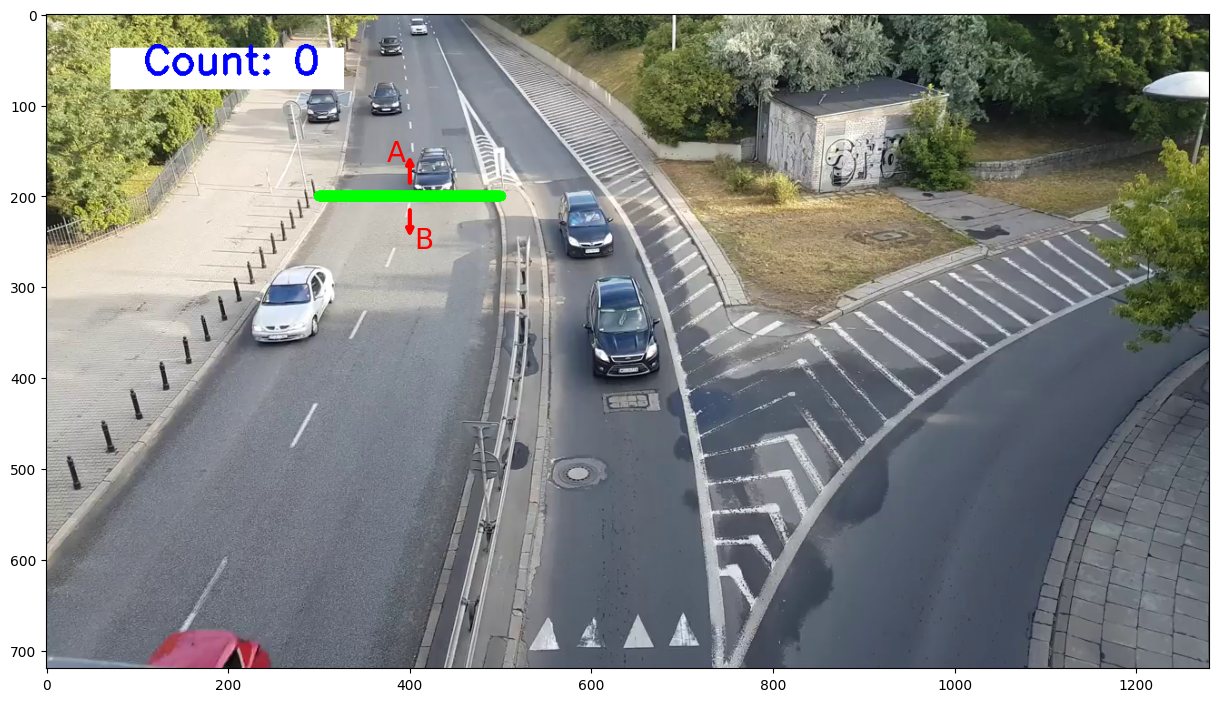

In [4]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
global car_count,x_line

#@markdown ### ---------------------------------------------------------------------------------------------------------------

#@markdown ### Please choose two points for the virtual car counter:

#@markdown ### Point 1:
point1_x=300 #@param {type:"integer"}
point1_y=200 #@param {type:"integer"}

#@markdown ### Point 2:

point2_x=500 #@param {type:"integer"}
point2_y=200 #@param {type:"integer"}


#@markdown ### Does the line position look good? If not, please reRun this block until the desired position is chosen.
global point1,point2
point1=(point1_x,point1_y)
point2=(point2_x,point2_y)

#@markdown ### ---------------------------------------------------------------------------------------------------------------
#@markdown ### Please choose the direction of the traffic:
global Direction
Direction="B" #@param ["A","B"]


cap=cv2.VideoCapture(video_path)
suc,image=cap.read()

w,h=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps=cap.get(cv2.CAP_PROP_FPS)
total_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

count_box=(int(w//18),int(h//19))

if suc:
  cv2.rectangle(image, count_box, (count_box[0]+w//5,count_box[1]+h//16), (255,255,255), -1)
  cv2.putText(image,'Count: 0',(count_box[0]+w//35,count_box[1]+h//25),cv2.FONT_HERSHEY_SIMPLEX,w/900,(255,0,0),w//350)
  cv2.line(image,point1,point2,(0,255,0),w//100)
  fig=plt.figure(figsize=(15,15))
  A,B=draw_arrows(fig.gca(), point1,point2,w,h)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()
else:
  print("Video is not loaded correctly. Check the video path")


# ***Step 3: Run the model***

Next, we need to set the parameters of the model. You can try the default values for most cases.

Multiple facotrs such as the quality of video, fps, type of errors most avoided, and the camera distance from the cars can play a role here.

You can also choose between different YOLO model sizes based on the trade off of accuracy and processing speed.

In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
# from utils.metrics import box_iou
import math
import datetime

#@markdown ### Set output video path:
output_directory='/content/output' #@param {type:"string"}
#@markdown ### Set output video name:
output_video_name='output_video.mp4' #@param {type:"string"}
#@markdown ---

if not os.path.exists(output_directory): os.mkdir(output_directory)

out = cv2.VideoWriter(os.path.join(output_directory,output_video_name),
                      cv2.VideoWriter_fourcc('M','P','4','V'),
                      fps,(w,h))

#@markdown ### Set YOLO type (normal, small, medium, large, xlarge):
checkpoint:str ="yolov5s" #@param ["yolov5n", "yolov5s", "yolov5m", "yolov5l", "yolov5x"]
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

#@markdown ### Set NMS confidence threshold for YOLO:
model.conf = 0.25  #@param {type:"number"} # NMS confidence threshold
#@markdown ### Set NMS IoU threshold for YOLO:
model.iou = 0.4  #@param {type:"number"} # NMS IoU threshold
model.agnostic = True  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.classes = [1,2,3,5,7]  # (optional list) filter by class # [1,2,3,5,7] =bicycle,car,motorcycle,bus,truck
model.max_det = 100  # maximum number of detections per image
# model.amp = False  # Automatic Mixed Precision (AMP) inference
model.cuda()

#@markdown ### Set tracking IoU match ratio treshhold:
tracking_iou_match_ratio=0.3 #@param {type:"number"}

# @markdown ---
#@markdown ### Print parameters:
print_count_every_n_frame=100 #@param {type:"integer"}
# print_frame_number_when_count_changes=True #@param {type:"boolean"}


global car_dic
car_dic=dict()
global frame_n
frame_n=0
global car_count
car_count=1
car_dic[0]=0


prev_frame_car_count=car_count
tic=datetime.datetime.now()
print('This video has a total of {} frames'.format(total_frames))
while True:
  success,image=cap.read()
  frame_n+=1
  if not success:
    break

  results = model(image)

  if frame_n==1:
    prev_results=results

  car_count,car_dic=check_if_just_passed_line(prev_results,results)
  showing_image=results.ims[0]
  cv2.rectangle(showing_image, count_box, (count_box[0]+w//5,count_box[1]+h//16), (255,255,255), -1)
  cv2.putText(showing_image,'Count: {}'.format(car_count),(count_box[0]+w//35,count_box[1]+h//25),cv2.FONT_HERSHEY_SIMPLEX,w/900,(255,0,0),w//350)
  showing_image=annotate_yolo_results(results,image, confidence_threshold=0.5)
  cv2.line(showing_image,point1,point2,(0,255,0),w//100)
  out.write(cv2.cvtColor(showing_image, cv2.COLOR_BGR2RGB))
  tac=datetime.datetime.now()
  frames_remaining=total_frames-frame_n
  remain_time=int(np.floor((((tac-tic).total_seconds()*frames_remaining)/frame_n)))
  if frame_n%print_count_every_n_frame==0:
    print('Cars counted: {}  at frame :{} , Frames remaining= {}, Estimated remaining time= {} seconds'.format(car_count,frame_n,frames_remaining,remain_time))
  prev_frame_car_count=car_count
  prev_results=results

out.release()
import pandas as pd
veh_df=pd.DataFrame(car_dic,index=[0]).transpose().rename(columns={0:'frame_n'})
veh_df['time_stamp']=veh_df.apply(lambda x:x/fps)
veh_df=veh_df.reset_index()
veh_df.rename(columns={'index':'veh_n'},inplace=True)
veh_df.veh_n.apply(lambda x:x+1)
veh_df.to_csv(os.path.join(output_directory,'veh_df.csv'))
print('Done')



/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.0.1'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.

This video has a total of 9184 frames
Cars counted: 4  at frame :100 , Frames remaining= 9084, Estimated remaining time= 439 seconds
Cars counted: 7  at frame :200 , Frames remaining= 8984, Estimated remaining time= 352 seconds
Cars counted: 10  at frame :300 , Frames remaining= 8884, Estimated remaining time= 324 seconds
Cars counted: 15  at frame :400 , Frames remaining= 8784, Estimated remaining time= 355 seconds
Cars counted: 17  at frame :500 , Frames remaining= 8684, Estimated remaining time= 336 seconds
Cars counted: 19  at frame :600 , Frames remaining= 8584, Estimated remaining time= 319 seconds
Cars counted: 21  at frame :700 , Frames remaining= 8484, Estimated remaining time= 307 seconds
Cars counted: 24  at frame :800 , Frames remaining= 8384, Estimated remaining time= 304 seconds


# **Step 4: Aggregating Data**

In [ ]:
#@markdown ### Choose the time aggregation range (in seconds):
Aggregation_range = 30  #@param {type:"number"} # NMS IoU threshold

out_df=pd.Series(range(len(veh_df)),
                 index=veh_df.time_stamp.apply
                (lambda x:datetime.timedelta(seconds=x))).resample('{}S'.format(Aggregation_range)).max()
out_df=out_df.reset_index()
out_df['time_stamp']=out_df['time_stamp'].apply(lambda x:int(x.total_seconds()))
out_df.rename(columns={0:'veh_count'},inplace=True)

out_df.to_csv(os.path.join(output_directory,'Aggregate_veh_df_{}S.csv'.format(Aggregation_range)))
print(out_df.head())

   time_stamp  veh_count
0           0         26
1          30         48
